In [1]:
import random
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from gymnasium.utils.env_checker import check_env
import gymnasium as gym
from gridworld_env.GridWorld import GridWorldEnv

torch.cuda.empty_cache()

SEED = 50

random.seed(SEED)
torch.manual_seed(SEED)

# --- Configuración de Gráficos (si se ejecuta en un notebook) ---
is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# --- Configuración del Dispositivo (GPU o CPU) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --- Clase ReplayBuffer (Memoria de Repetición) ---
# (La misma que discutimos antes)
Experience = namedtuple('Experience', ('state', 'action', 'next_state', 'reward'))

class ReplayBuffer:
    """Memoria de tamaño fijo para almacenar tuplas de experiencia."""

    def __init__(self, capacity):
        """
        Inicializador.

        Args:
            capacity (int): Tamaño máximo del buffer.
        """
        # deque es una lista optimizada para añadir y quitar elementos de los extremos
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Guarda una nueva experiencia en la memoria."""
        self.memory.append(Experience(*args))

    def sample(self, batch_size):
        """
        Obtiene una muestra aleatoria de 'batch_size' experiencias.

        Args:
            batch_size (int): El tamaño del minibatch a muestrear.
        """
        return random.sample(self.memory, batch_size)

    def __len__(self):
        """Devuelve el tamaño actual de la memoria."""
        return len(self.memory)
    
class DQN(nn.Module):
    """
    Una red neuronal simple para aproximar la función Q.
    """
    def __init__(self, n_observations, n_actions):
        """
        Inicializador.

        Args:
            n_observations (int): La dimensionalidad del espacio de estados.
                                (Ej: 4 para CartPole).
            n_actions (int): El número de acciones discretas posibles.
                            (Ej: 2 para CartPole, izquierda o derecha).
        """
        super(DQN, self).__init__()
        # Definimos las capas de la red
        self.layer1 = nn.Linear(n_observations, 16)
        self.layer2 = nn.Linear(16, 16)
        self.layer3 = nn.Linear(16, n_actions)

    def forward(self, x):
        """
        El paso hacia adelante (forward pass).
        Define cómo la entrada (estado) se transforma en la salida (valores Q).
        """
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        # La salida no lleva función de activación porque queremos los valores Q brutos.
        return self.layer3(x)

Using device: cuda


In [2]:

    
# --- Hiperparámetros ---
BATCH_SIZE = 32       # Tamaño del minibatch muestreado del buffer
GAMMA = 0.99          # Factor de descuento
EPS_START = 1         # Valor inicial de épsilon (exploración)
EPS_END = 0.05        # Valor final de épsilon
EPS_DECAY = 50        # Tasa de decaimiento de épsilon
TAU = 0.005           # Tasa de actualización de la red objetivo (soft update)
LR = 1e-4             # Tasa de aprendizaje para el optimizador AdamW

WARMUP_EPISODES = 20 # Pasos de exploración pura antes de optimizar

# --- Inicialización de Entorno ---
size = 9
goal = (0,0)

env = gym.make("entropia/GridWorld-v0", size=size, reward_scale=10, step_penalty=0.5, render_mode="human")
check_env(env.unwrapped)

n_actions = env.action_space.n
state_obs, info = env.reset(options={"agent_start": (size//2, size//2), "goal": goal})
n_observations = len(GridWorldEnv.transform_obs(state_obs))

# Red principal y red objetivo
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict()) # Copiamos los pesos

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayBuffer(500)

e_counter = 0
episode_durations = []

. . . . . . . . .
. . . . . . . . .
. A . . . . . . .
. . . . . . . . .
. . . . . . . . .
. . . . . . . . .
. . . . . . . . .
. . . . . . . . .
. . . . . T . . .
 0 1 2 3 4 5 6 7 8
. . . . . . . . .
. . . . . . . . .
A . . . . . . . .
. . . . . . . . .
. . . . . . . . .
. . . . . . . . .
. . . . . . . . .
. . . . . . . . .
T . . . . . . . .
 0 1 2 3 4 5 6 7 8


In [3]:


# --- Funciones Auxiliares ---

def select_action(state, e_counter):
    """
    Selecciona una acción usando la estrategia épsilon-greedy.
    """
    #global e_counter

    # 1. Fase de Warm-up: exploración pura para llenar el buffer
    if e_counter < WARMUP_EPISODES:
        #e_counter += 1
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

    # 2. Fase de Épsilon-Greedy# 2. Fase de Épsilon-Greedy
    sample = random.random()
    # Cálculo de épsilon con decaimiento exponencial
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * (e_counter - WARMUP_EPISODES) / EPS_DECAY)
    #e_counter += 1
    if sample > eps_threshold:
        # Explotación: elegimos la mejor acción según la red
        with torch.no_grad():
            # .max(1) devuelve el valor máximo y el índice de ese valor.
            # Solo necesitamos el índice (la acción).
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        # Exploración: elegimos una acción aleatoria
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

def plot_durations(show_result=False):
    """
    Función para graficar el progreso del entrenamiento.
    """
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Tomamos el promedio de los últimos 10 episodios para ver la tendencia
    if len(durations_t) >= 10:
        means = durations_t.unfold(0, 10, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(9), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # Pausa para que el gráfico se actualice
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


# --- Bucle de Entrenamiento Principal ---

def optimize_model():
    """
    Realiza un paso de optimización en la red principal.
    """
    if len(memory) < BATCH_SIZE:
        return # No hacemos nada si no hay suficientes experiencias

    transitions = memory.sample(BATCH_SIZE)
    # Transpone el batch. Convierte un batch de tuplas Experience
    # a una tupla de batches. Ej: (s1,s2,..), (a1,a2,..), etc.
    batch = Experience(*zip(*transitions))

    # Creamos máscaras para estados que no son finales
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                        batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # 1. Calcular Q(s, a) para las acciones que se tomaron
    # La red predice Q(s) para todas las acciones, y luego usamos .gather()
    # para seleccionar solo los valores de las acciones que realmente se tomaron.
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # 2. Calcular el valor del siguiente estado para DDQN
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    if non_final_mask.any():  # Only compute if there are non-final states
        with torch.no_grad():
            # 2.1. Seleccionar la mejor acción usando la policy_net
            best_actions = policy_net(non_final_next_states).argmax(1, keepdim=True)
            # 2.2. Evaluar el valor de esa acción usando la target_net
            q_values_target = target_net(non_final_next_states)
            next_state_values[non_final_mask] = q_values_target.gather(1, best_actions).squeeze(1)

    # 3. Calcular el TD Target: r + γ * V(s')
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # 4. Calcular la pérdida (Loss)
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # 5. Optimizar el modelo
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping para evitar explosiones de gradientes
    torch.nn.utils.clip_grad_norm_(policy_net.parameters(), max_norm=1.0)
    optimizer.step()

Complete


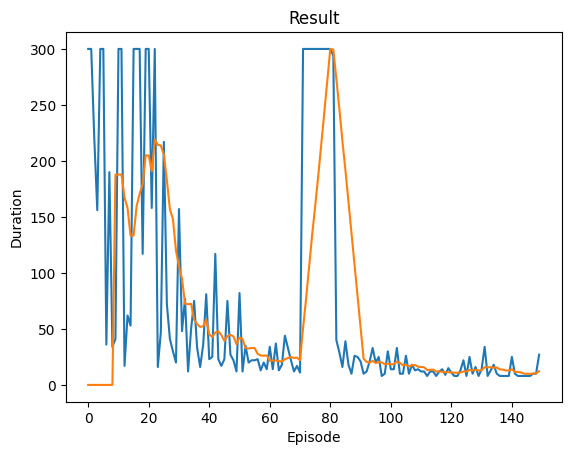

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [4]:
# --- Ejecución del Entrenamiento ---
num_episodes = 150

for i_episode in range(num_episodes):
    
    if i_episode<=70:
        state, info = env.reset(options={"agent_start": (size//2, size//2), "goal": (0,0)})
    else:
        state, info = env.reset(options={"agent_start": (size//2, size//2), "goal": (8,8)})

    state = GridWorldEnv.transform_obs(state)
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    
    for t in count():
        action = select_action(state, i_episode)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if done:
            next_state = None
        else:
            observation = GridWorldEnv.transform_obs(observation)
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
            
        # Guardar la transición en la memoria
        memory.push(state, action, next_state, reward)

        # Mover al siguiente estado
        state = next_state

        # Realizar un paso de optimización en la red principal
        optimize_model()

        # "Soft update" de los pesos de la red objetivo
        # θ_target = τ*θ_policy + (1 - τ)*θ_target
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

In [5]:
# Display animation of the agent in the environment
def display_animation(env, policy_net, num_episodes=1):
    """
    Display animation of the trained agent in the environment.
    
    Args:
        env: The gymnasium environment
        policy_net: The trained DQN policy network
        num_episodes: Number of episodes to display
    """
    policy_net.eval()  # Set to evaluation mode
        
    for episode in range(num_episodes):
        print(f"Episode {episode + 1}")
        state_obs, info = env.reset(options={"agent_start": (size//2, size//2), "goal": (2,2)})
        state = GridWorldEnv.transform_obs(state_obs)
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        
        step_count = 0
        done = False
        
        while not done:
            # Use the trained policy network to select action (greedy policy)
            with torch.no_grad():
                action = policy_net(state).max(1)[1].view(1, 1)
            
            # Take action in environment
            observation, reward, terminated, truncated, info = env.step(action.item())
            done = terminated or truncated
            
            # Transform observation for next step
            if not done:
                observation = GridWorldEnv.transform_obs(observation)
                state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
            
            step_count += 1
            
            # Render the environment
            env.render()
            
            # Safety check to avoid infinite loops
            if step_count > 300:
                print("Episode terminated after 300 steps")
                break
        
        print(f"Episode completed in {step_count} steps")
    
    env.close()

# Call the function to display the trained agent
display_animation(env, policy_net, num_episodes=3)




Episode 1
. . . . . . . . .
. . . . . . . . .
. . . . . . . . .
. . . . . . . . .
. . . . . A . . .
. . . . . . . . .
. . T . . . . . .
. . . . . . . . .
. . . . . . . . .
 0 1 2 3 4 5 6 7 8
. . . . . . . . .
. . . . . . . . .
. . . . . . . . .
. . . . . . . . .
. . . . . . A . .
. . . . . . . . .
. . T . . . . . .
. . . . . . . . .
. . . . . . . . .
 0 1 2 3 4 5 6 7 8
. . . . . . . . .
. . . . . . . . .
. . . . . . . . .
. . . . . . . . .
. . . . . . . A .
. . . . . . . . .
. . T . . . . . .
. . . . . . . . .
. . . . . . . . .
 0 1 2 3 4 5 6 7 8
. . . . . . . . .
. . . . . . . . .
. . . . . . . . .
. . . . . . . A .
. . . . . . . . .
. . . . . . . . .
. . T . . . . . .
. . . . . . . . .
. . . . . . . . .
 0 1 2 3 4 5 6 7 8
. . . . . . . . .
. . . . . . . . .
. . . . . . . A .
. . . . . . . . .
. . . . . . . . .
. . . . . . . . .
. . T . . . . . .
. . . . . . . . .
. . . . . . . . .
 0 1 2 3 4 5 6 7 8
. . . . . . . . .
. . . . . . . A .
. . . . . . . . .
. . . . . . . . .
. . . . . . .

In [6]:
import numpy as np

def plot_dqn_weights(model):
    """
    Función para visualizar las conexiones de la red DQN y sus pesos más relevantes.
    """
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Get the weights for each layer
    layer1_weights = model.layer1.weight.data.cpu().numpy()  # Shape: (16, 2)
    layer2_weights = model.layer2.weight.data.cpu().numpy()  # Shape: (16, 16)
    layer3_weights = model.layer3.weight.data.cpu().numpy()  # Shape: (4, 16)
    
    # Layer 1: Input to Hidden (2 -> 16)
    im1 = axes[0].imshow(layer1_weights, cmap='RdBu', aspect='auto')
    axes[0].set_title('Layer 1: Input → Hidden\n(2 inputs → 16 neurons)')
    axes[0].set_xlabel('Input Features')
    axes[0].set_ylabel('Hidden Neurons')
    axes[0].set_xticks([0, 1])
    axes[0].set_xticklabels(['Feature 1', 'Feature 2'])
    plt.colorbar(im1, ax=axes[0], label='Weight Value')
    
    # Add weight values as text
    for i in range(layer1_weights.shape[0]):
        for j in range(layer1_weights.shape[1]):
            axes[0].text(j, i, f'{layer1_weights[i,j]:.2f}', 
                        ha='center', va='center', fontsize=8)
    
    # Layer 2: Hidden to Hidden (16 -> 16)
    im2 = axes[1].imshow(layer2_weights, cmap='RdBu', aspect='auto')
    axes[1].set_title('Layer 2: Hidden → Hidden\n(16 → 16 neurons)')
    axes[1].set_xlabel('Input Hidden Neurons')
    axes[1].set_ylabel('Output Hidden Neurons')
    plt.colorbar(im2, ax=axes[1], label='Weight Value')
    
    # Layer 3: Hidden to Output (16 -> 4)
    im3 = axes[2].imshow(layer3_weights, cmap='RdBu', aspect='auto')
    axes[2].set_title('Layer 3: Hidden → Output\n(16 neurons → 4 actions)')
    axes[2].set_xlabel('Hidden Neurons')
    axes[2].set_ylabel('Output Actions')
    axes[2].set_yticks([0, 1, 2, 3])
    axes[2].set_yticklabels(['Action 0', 'Action 1', 'Action 2', 'Action 3'])
    plt.colorbar(im3, ax=axes[2], label='Weight Value')
    
    # Add weight values as text for output layer
    for i in range(layer3_weights.shape[0]):
        for j in range(layer3_weights.shape[1]):
            axes[2].text(j, i, f'{layer3_weights[i,j]:.2f}', 
                        ha='center', va='center', fontsize=6)
    
    plt.tight_layout()
    plt.show()
    
    # Print the most important connections
    print("\nMost relevant connections:")
    print("="*50)
    
    # Layer 1: Find strongest connections from inputs
    print("Layer 1 (Input → Hidden):")
    for input_idx in range(layer1_weights.shape[1]):
        strongest_neuron = np.argmax(np.abs(layer1_weights[:, input_idx]))
        strongest_weight = layer1_weights[strongest_neuron, input_idx]
        print(f"  Input {input_idx} → Hidden {strongest_neuron}: {strongest_weight:.3f}")
    
    # Layer 3: Find strongest connections to outputs
    print("\nLayer 3 (Hidden → Output):")
    for action_idx in range(layer3_weights.shape[0]):
        strongest_neuron = np.argmax(np.abs(layer3_weights[action_idx, :]))
        strongest_weight = layer3_weights[action_idx, strongest_neuron]
        print(f"  Hidden {strongest_neuron} → Action {action_idx}: {strongest_weight:.3f}")

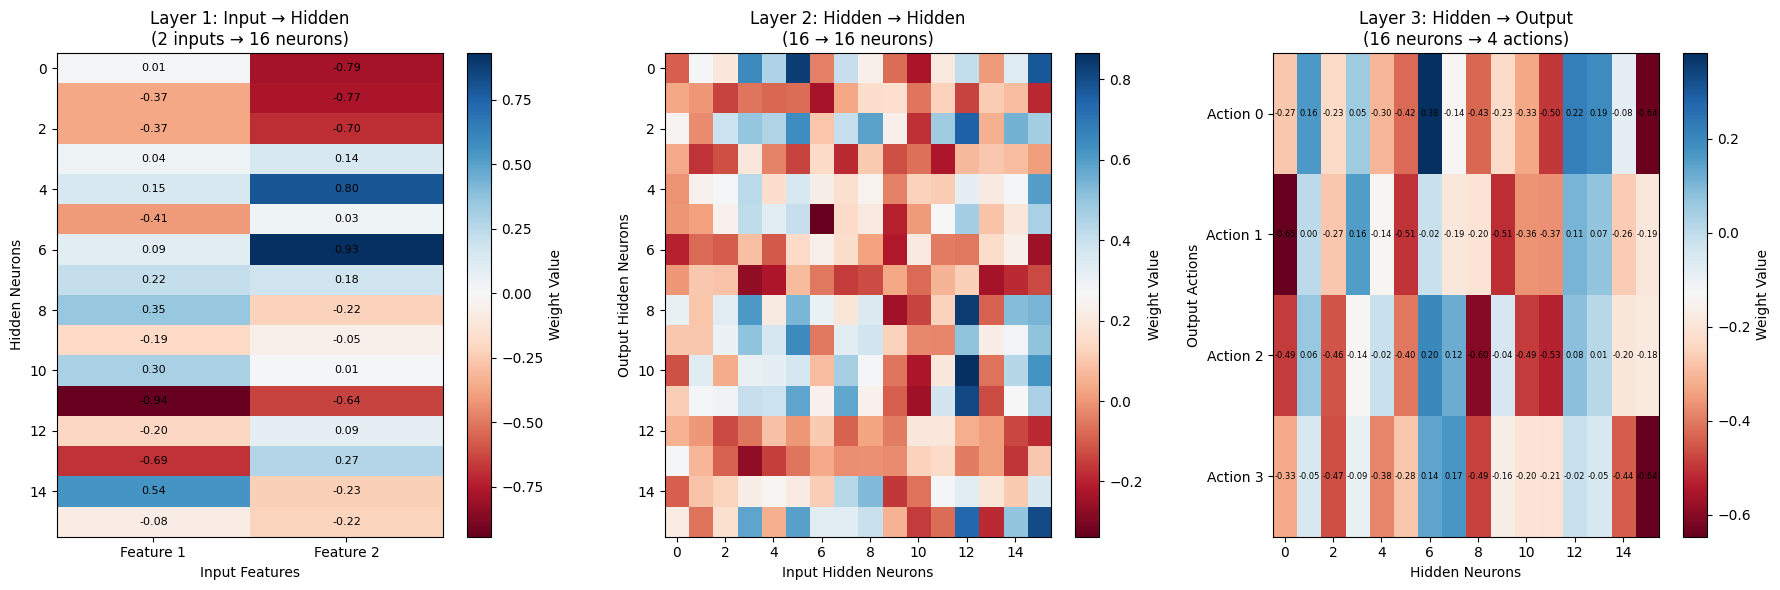


Most relevant connections:
Layer 1 (Input → Hidden):
  Input 0 → Hidden 11: -0.944
  Input 1 → Hidden 6: 0.930

Layer 3 (Hidden → Output):
  Hidden 15 → Action 0: -0.638
  Hidden 0 → Action 1: -0.647
  Hidden 8 → Action 2: -0.602
  Hidden 15 → Action 3: -0.643


In [7]:
plot_dqn_weights(policy_net)